## Topic 3: Classify Song Lyrics according to Genre
In diesem Projekt wird überprüft inwiefern man mit Hilfe von Deep Learning das Genre eines Songs anhand seiner Lyrics vorhersagen kann. Die für dieses Projekt genutzten Daten stammen von https://www.kaggle.com/ und beinhalten Songtexte von über 200.000 Liedern von 3242 Artisten.

## Daten
Die Daten sind in zwei csv-Dateien aufgeteilt. In der Datei "artists-data.csv" werden Informationen zu den Artisten in der Form Artist, Songs, Popularity, Link, Genre, Genres gespeichert. Die Informationen zu den Songtext findet man in der Datei "lyrics-data.csv" in der Form ALink, SName, SLink, Lyric, Idiom.


Mit Hilfe des Moduls Pandas können die csv Dateien in sogenannte DataFrames gelesen werden, die die weitere Verarbeitung vereinfachen. Aufgrund der Aufgabenstellung werden nur englische Songtexte betrachtet. Die englischen Songtexte können anhand der Spalte Idiom erkannt werden. So werden alle Songtexte die in dieser Spalte nicht den Wert „English“ haben herausgefiltert. Es bleiben 114723 Songtexte übrig.

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras import layers
from collections import Counter 

artists_path = "data/artists-data.csv"
lyrics_path = "data/lyrics-data.csv"

artists_data = pandas.read_csv(artists_path)
lyrics_data = pandas.read_csv(lyrics_path)
# lyrics_data = lyrics_data.drop_duplicates(subset ="ALink")

# nur Englische Texte betrachten
lyrics_data = lyrics_data[lyrics_data["Idiom"] == 'ENGLISH']

Um die Songtexte mit dem Genre zu verbinden werden nur die Spalten "ALink" und "Lyric" des lyrics_data DataFrames benötigt, sowie die Spalten "Link" und "Genre" des artists_data DataFrames benötigt. Alle anderen Spalten werden nicht mehr gebraucht.

In [2]:
# Überflüssige Spalten enfternen
lyrics_data = lyrics_data.drop(['SName', 'SLink', 'Idiom'], axis=1)

# Überflüssige Spalten enfternen
artists_data = artists_data.drop(['Songs', 'Popularity', 'Artist', 'Genres'], axis=1)

Zudem werden die Songtexte in Kleinbuchstaben umgewandelt.

In [3]:
# Lyrics in Kleinbuchstaben kovertieren
lyrics_data["Lyric"] = lyrics_data["Lyric"].apply(lambda x: x.lower())

Aufgrund erster Analysen konnten wird herausfinden, dass für die Genres „Sertanejo“, „Funk Carioca“ und „Samba“ nur ein sehr geringer Anteil an Songtexten in den Daten enthalten war. So sind diese Genres nur insgesamt 243 mal aufgetreten. Da dieser Anteil sehr gering ist konzentrieren wir uns auf die drei hauptsächlich vorkommenden Genres "Rock, "Hip Hop" und "Pop".

In [4]:
# Sertanejo(87), Funk Carioca(104) und Samba(52) kommen in den englischsprachigen Lyrics zu selten vor
artists_data = artists_data[artists_data.Genre.isin(['Rock', 'Hip Hop', 'Pop'])]

Nun werden die beiden DataFrames zu einem vereint. Dies geschieht mit Hilfe der merge()-Methode, ebenfalls aus dem Modul "pandas". Wie bereits angesprochen werden die DataFrames aufgrund der Gleichheit der Spalten "ALink" und "Link" gemergt.

In [5]:
# Dataframes mergen, immer dann wenn 'ALink' == 'Link'
merged_data = pandas.merge(lyrics_data, artists_data, how='inner', left_on='ALink', right_on='Link')

Nun werden die Spalten "Link" und "ALink" ebenfalls nicht mehr benötigt. Alle übrigen Zeilen enthalten nun einen Songtext und das Genre, dem der zugehörige Artist, und somit auch der Songtext selbst, zugeordnet ist.

In [6]:
# Überflüssige Spalten enfternen
merged_data = merged_data.drop(['Link', 'ALink'], axis=1)
print(merged_data)

                                                    Lyric Genre
0       i could feel at the time. there was no way of ...  Rock
1       i could feel at the time. there was no way of ...   Pop
2       take me now, baby, here as i am. hold me close...  Rock
3       take me now, baby, here as i am. hold me close...   Pop
4       these are. these are days you'll remember. nev...  Rock
...                                                   ...   ...
123982  her face is a map of the world, is a map of th...  Rock
123983  i can't believe the news today. i can't close ...  Rock
123984  i was so high i did not recognize. the fire bu...  Rock
123985  well sometimes i go out by myself. and i look ...  Rock
123986  feeling my way through the darkness. guided by...  Rock

[123987 rows x 2 columns]


Um einen Überblick über die verbleibenden Daten zu erhalten werden diese in Diagrammen dargestellt. Hierzu benötigen wir eine Liste aller noch vorhandenen Genres. Zudem benötigen wir die Anzahl der Songtexte insgesamt, sowie die Anzahl der Songtexte pro Genre. Mit diesen Daten können wir den prozentualen Anteil jedes Genres berechnen. Die Daten werden mithilfe des Moduls „matplotlib“ visualisiert.

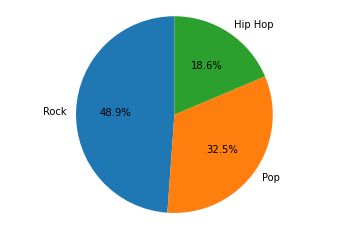

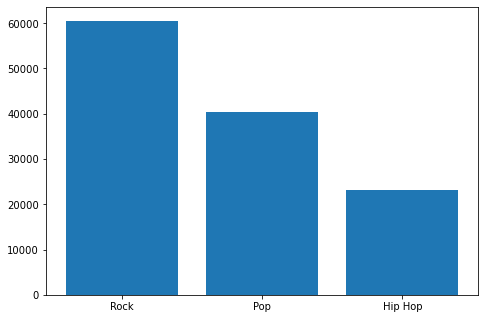

In [10]:
# Anzahl der übrig gebliebenen Songtexte
nr_of_songs = merged_data.count()[0]

# Einzigartige Werte für das Genre herausfinden
genres = merged_data['Genre'].unique()

# Zweite Liste die die Anzahl der Songs pro Genre enthält
songs_in_genre = []
for genre in genres:
    songs_in_genre.append((merged_data["Genre"] == genre).value_counts()[1])                          

# Werte in songs_in_genre durch nr_of_songs um prozentualen Anteil zu erhalten
songs_in_genre_percent = songs_in_genre / nr_of_songs

# Diagramm erstellen
fig1, ax1 = plt.subplots()
ax1.pie(songs_in_genre_percent, labels=genres, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(genres, songs_in_genre)
plt.show()


Um als Eingabe für unsere späteren Modelle zu dienen werden die beiden Spalten in einzelne Vektoren aufgeteilt.

In [8]:
lyrics_vec =  merged_data['Lyric']
genre_vec =  merged_data['Genre']

print(lyrics_vec)
print(genre_vec)

0         i could feel at the time. there was no way of ...
1         i could feel at the time. there was no way of ...
2         take me now, baby, here as i am. hold me close...
3         take me now, baby, here as i am. hold me close...
4         these are. these are days you'll remember. nev...
                                ...                        
123982    her face is a map of the world, is a map of th...
123983    i can't believe the news today. i can't close ...
123984    i was so high i did not recognize. the fire bu...
123985    well sometimes i go out by myself. and i look ...
123986    feeling my way through the darkness. guided by...
Name: Lyric, Length: 123987, dtype: object
0         Rock
1          Pop
2         Rock
3          Pop
4         Rock
          ... 
123982    Rock
123983    Rock
123984    Rock
123985    Rock
123986    Rock
Name: Genre, Length: 123987, dtype: object
